In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
%matplotlib inline

import gc
from time import time
import datetime
import multiprocessing
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp


from tqdm import tqdm, tqdm_notebook
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit, train_test_split
from sklearn.metrics import roc_auc_score

from reduce_mem_usage import reduce_mem_usage

In [3]:
warnings.simplefilter('ignore')
sns.set()

In [4]:
train = pd.read_csv('input/train_w_fe.csv')
test = pd.read_csv('input/test_w_fe.csv')

# Remove some cols and split 

In [5]:
TARGET = 'isFraud'

In [6]:
rm_cols = [
    'TransactionID', 'TransactionDT',  # These columns are pure noise right now
    TARGET,                            # Not target in features))
    'uid', 'uid2', 'uid3',             # Our new client uID -> very noisy data
    'bank_type',                       # Victims bank could differ by time
    'DT', 'DT_M', 'DT_W', 'DT_D',      # Temporary Variables
    'DT_hour', 'DT_day_week', 'DT_day',
    'DT_D_total', 'DT_W_total', 'DT_M_total',
    'id_30', 'id_31', 'id_33',
]

features_columns = [col for col in list(train) if col not in rm_cols]

# The June month drops entirely
train['random_noise'] = np.random.randn(len(train))
print(train['DT'].max())
print(test['DT'].min())
# So we need to get rid of April and keep May as validation set
X_train = train[train['DT'] <= '2018-03-31']
y_train = X_train[TARGET]
X_train = X_train[features_columns]
X_valid = train[(train['DT'] >= '2018-05-01')]
y_valid = X_valid[TARGET]
X_valid = X_valid[features_columns]

2018-05-31 23:58:51
2018-07-01 00:00:24


# Subsample

In [7]:
pos_class = X_train[y_train == 1]
neg_class = X_train[y_train == 0].sample(frac=0.1, random_state=42)

X_subsample = pd.concat([pos_class, neg_class])
X_subsample = X_subsample.sample(frac=1)  # quick way to shuffle
y_subsample = y_train[X_subsample.index]
assert len(X_subsample) == len(y_subsample)
assert (X_subsample.index == y_subsample.index).all()

# Most important variables treatment

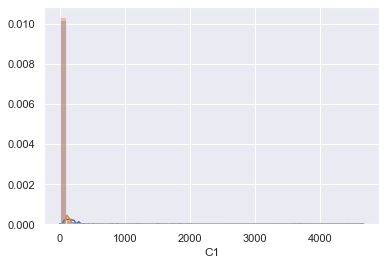

In [9]:
sns.distplot(X_subsample[y_subsample == 1]['C1'])
sns.distplot(X_subsample[y_subsample == 0]['C1'])

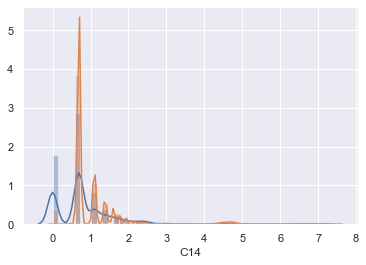

In [11]:
sns.distplot(np.log1p(X_subsample[y_subsample == 1]['C14']))
sns.distplot(np.log1p(X_subsample[y_subsample == 0]['C14']))

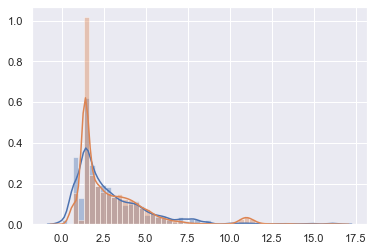

In [14]:
sns.distplot(np.log1p(X_subsample[y_subsample == 1]['C13']) +
             np.log1p(X_subsample[y_subsample == 1]['C1']))
sns.distplot(np.log1p(X_subsample[y_subsample == 0]['C13']) +
             np.log1p(X_subsample[y_subsample == 0]['C1']))

In [16]:
(X_subsample[y_subsample == 0]['C1'].value_counts() /
 len(X_subsample[y_subsample == 0]))[:10]

1.0     0.557134
2.0     0.175026
3.0     0.083963
4.0     0.044632
5.0     0.027229
6.0     0.017153
7.0     0.011277
8.0     0.008676
9.0     0.005526
10.0    0.004951
Name: C1, dtype: float64

In [17]:
(X_subsample[y_subsample == 1]['C1'].value_counts() /
 len(X_subsample[y_subsample == 1]))[:10]

1.0     0.375205
2.0     0.154384
3.0     0.082945
4.0     0.052466
5.0     0.051096
6.0     0.029384
7.0     0.020890
8.0     0.015411
10.0    0.013562
Name: C1, dtype: float64

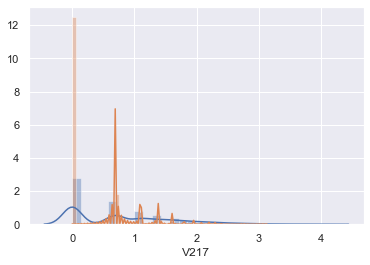

In [18]:
sns.distplot(np.log1p(X_subsample[y_subsample == 1]['V217'].dropna()))
sns.distplot(np.log1p(X_subsample[y_subsample == 0]['V217'].dropna()))

### some V cols 

In [20]:
y_subsample[X_subsample[X_subsample['V217'].isnull()].index].value_counts()

0    30614
1     7308
Name: isFraud, dtype: int64

In [21]:
y_subsample[X_subsample[X_subsample['V217'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [22]:
y_subsample[X_subsample[X_subsample['V218'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [23]:
y_subsample[X_subsample[X_subsample['V219'].notnull()].index].value_counts()

0    9380
1    7292
Name: isFraud, dtype: int64

In [25]:
(X_subsample['V218'].notnull().index == X_subsample['V217'].notnull().index).all()

True

In [27]:
(X_subsample[X_subsample['V217'].notnull()]['V218'] ==
 X_subsample[X_subsample['V218'].notnull()]['V219']).mean()

0.9198656429942419

In [28]:
(X_subsample['V217'].notnull() ==
 X_subsample['V219'].notnull()).all()

True

In [29]:
X_subsample[['V217', 'V218', 'V219']].sample(18)

,V217,V218,V219
76466,0.0,0.0,0.0
187604,NaN,NaN,NaN
297126,NaN,NaN,NaN
254895,NaN,NaN,NaN
390108,0.0,0.0,0.0
212891,NaN,NaN,NaN
104695,0.0,0.0,0.0
409959,0.0,1.0,0.0
91642,NaN,NaN,NaN
401337,NaN,NaN,NaN
